In [1]:
import csv
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
phase = '2'
root_path = f"/Users/han/Desktop/UW/GLOBEM/GLOBEM_Datasets_NeurIPS22/INS-W_{phase}/"
demo_data_path = root_path + "SurveyData/demo.csv"
dep_data_path = root_path + "SurveyData/dep_weekly_.csv"
dep_bdi_data_path = root_path + "SurveyData/dep_endterm.csv"
ema_collection_time_path = root_path + "configs/ema-collection_time.json"

In [3]:
demo = pd.read_csv(demo_data_path,low_memory=False)
dep_weekly = pd.read_csv(dep_data_path,low_memory=False)
dep_endterm = pd.read_csv(dep_bdi_data_path,low_memory=False)

with open(ema_collection_time_path, 'r') as f:
    ema_collection_time = json.load(f)

In [4]:
def trim_data(data, phase):
    """
    This function is to extract the data in a specific time period, e.g., Spring quarter.
    """
    if phase == '1':
        start_date_spr = '2018-03-26'
        end_date_spr = '2018-06-03'
    if phase == '2':
        start_date_spr = '2019-04-01'
        end_date_spr = '2019-06-07'
    if phase == '3':
        start_date_spr = '2020-03-29'
        end_date_spr = '2020-06-05'
    if phase == '4':
        start_date_spr = '2021-03-28'
        end_date_spr = '2021-06-04'
    print('Only use data between {} and {}.'.format(start_date_spr, end_date_spr))
    data_spr = data[data['date'].between(start_date_spr, end_date_spr)]
    print('Done!')
    print('\n')
    return data_spr

In [5]:
def demo_preprocessing(data):
    
    data['gender_DEMO'] = data['gender_DEMO'] != 1
    data['gender_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['student_international_DEMO'] = data['student_international_DEMO'] != 0
    data['student_international_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['student_1stGen_DEMO'] = data['student_1stGen_DEMO'] != 0
    data['student_1stGen_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['gender_DEMO'].replace({1:'non-male',0:'male'},inplace=True)
    data['orientation_heterosexual_DEMO'].replace({1:'heterosexual',0:'non-heterosexual'},inplace=True)
    data['student_international_DEMO'].replace({1:'international',0:'non-international'},inplace=True)
    data['student_1stGen_DEMO'].replace({1:'first-gen',0:'non-first-gen'},inplace=True)
    data['parent_edu_mother_DEMO'].replace({1:'bachelor and above',0:'below bachelor'},inplace=True)
    data['parent_edu_father_DEMO'].replace({1:'bachelor and above',0:'below bachelor'},inplace=True)
    data['generation_DEMO'].replace({1:'immigrant',0:'non-immigrant'},inplace=True)
    data['race_asian_DEMO'] = (data['race_DEMO'] == 'Asian').replace({True:'asian',False:'non-asian'})
    data['race_black_DEMO'] = (data['race_DEMO'] == 'Black').replace({True:'black',False:'non-black'})
    data['race_white_DEMO'] = (data['race_DEMO'] == 'White').replace({True:'white',False:'non-white'})
    data['race_latinx_DEMO'] = (data['race_DEMO'] == 'Latinx').replace({True:'latinx',False:'non-latinx'})
    data['race_biracial_DEMO'] = (data['race_DEMO'] == 'Biracial').replace({True:'biracial',False:'non-biracial'})
    if phase == '1':
        data['college_engineer_DEMO'].replace({1:'engineering',0:'non-engineering'},inplace=True)
    else:
        data['disability_DEMO'].replace({1:'disabled',0:'non-disabled'},inplace=True)
    
    data = data.set_index('pid')
    data.rename(columns = {col: '_'.join(col.split('_')[:-1]) for col in data.columns}, inplace=True)
    if phase == '1':
        data = data.rename(columns={'orientation_heterosexual':'orientation','student_international':'international student',
                 'student_1stGen': 'first-gen student','parent_edu_mother':"mom's edu",'parent_edu_father':"dad's edu",
                                    'race_asian': 'asian', 'race_black': 'black', 'race_white': 'white', 'race_latinx': 'latinx', 'race_biracial': 'biracial',
                                   'college_engineer':'college'})
        data.drop(columns='college',inplace=True) # comment out if the analysis of college is needed
    else:
        data = data.rename(columns={'orientation_heterosexual':'orientation','student_international':'international student',
                                    'race_asian': 'asian', 'race_black': 'black', 'race_white': 'white', 'race_latinx': 'latinx', 'race_biracial': 'biracial',
                 'student_1stGen': 'first-gen student','parent_edu_mother':"mom's edu",'parent_edu_father':"dad's edu"})
        data.drop(columns='disability',inplace=True) # comment out if the analysis of disability is needed
    
    return data.reset_index('pid')

In [6]:
demo = demo_preprocessing(demo)

In [7]:
dep_weekly = trim_data(dep_weekly,phase)

Only use data between 2019-04-01 and 2019-06-07.
Done!




In [8]:
demo_cols = demo.set_index(['pid','black','asian','latinx','international student']).columns.tolist()
print(f'{len(demo_cols)} demographics to compare.')

9 demographics to compare.


In [9]:
df_weekly = dep_weekly.merge(demo,on='pid',how='left')
df_endterm = dep_endterm.merge(demo,on='pid',how='left')

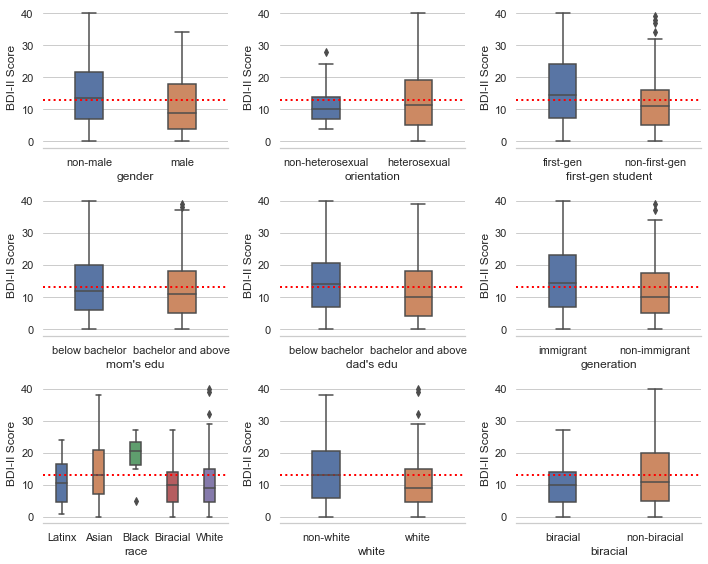

In [10]:
fig, axes = plt.subplots(nrows=3,ncols=3,sharey='col',figsize=(10,8))

idx = 0
for i in range(3):
    for j in range(3):
        title = demo_cols[idx]
        if demo_cols[idx] == 'gender':
            order = ['non-male','male']
        elif demo_cols[idx] == 'race':
            order = ['Latinx','Asian','Black','Biracial','White']
        elif demo_cols[idx] == 'orientation':
            order = ['non-heterosexual','heterosexual']
#         elif demo_cols[idx] == 'international student':
#             order = ['international','non-international']
        elif demo_cols[idx] == 'white':
            order = ['non-white','white']
        elif demo_cols[idx] == 'biracial':
            order = ['biracial','non-biracial']
        elif demo_cols[idx] == 'first-gen student':
            order = ['first-gen', 'non-first-gen']
        elif demo_cols[idx] == "mom's edu":
            order = ['below bachelor', 'bachelor and above']
        elif demo_cols[idx] == "dad's edu":
            order = ['below bachelor', 'bachelor and above']
        elif demo_cols[idx] == 'generation':
            order = ['immigrant', 'non-immigrant']
#         elif demo_cols[idx] == 'disability':
#             order = ['disabled', 'non-disabled']
#         elif demo_cols[idx] == 'college':
#             order = ['engineering','non-engineering']
#         lengths = 
        sns.boxplot(ax=axes[i][j], data=df_endterm, y='BDI2',x=demo_cols[idx], order=order, width=0.3)
        axes[i][j].tick_params(axis='x', labelbottom=True)  
        axes[i][j].axhline(y = 13, color = "red", linestyle = ":", linewidth = 2)
#         axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('BDI-II Score',fontsize=12)
        sns.despine(top=True, right=True, left=True, bottom=False)
        plt.tight_layout()
        idx+=1
plt.savefig(root_path + "vis/boxplot_BDI2.pdf", dpi = 300, bbox_inches = "tight")
# plt.show()

### Statistical Analysis

In [11]:
demo_cols.remove('race')
stats_results = {}
results = pd.DataFrame()
for demo_col in demo_cols:
    stats_results[demo_col] = {}
    stats_results[demo_col]['stats'] = []
    stats_results[demo_col]['p'] = []
    df_endterm.dropna(axis=0,inplace=True)
    group_mean = df_endterm[['BDI2']+[demo_col]].groupby(demo_col).mean().rename(columns={'BDI2':'mean'})
    group_median = df_endterm[['BDI2']+[demo_col]].groupby(demo_col).median().rename(columns={'BDI2':'median'})
    group_max = df_endterm[['BDI2']+[demo_col]].groupby(demo_col).max().rename(columns={'BDI2':'max'})
    group_min = df_endterm[['BDI2']+[demo_col]].groupby(demo_col).min().rename(columns={'BDI2':'min'})
    group_std = df_endterm[['BDI2']+[demo_col]].groupby(demo_col).std().rename(columns={'BDI2':'std'})
    result = pd.concat([group_mean, group_median, group_max, group_min,group_std], axis=1).reset_index()
    result.rename(columns={demo_col:'attributes'},inplace=True)
    if results.shape[0] == 0:
        results = result
    else:
        results = pd.concat([results,result],axis=0)
    values = df_endterm['BDI2'].tolist()
    group_labels = df_endterm[demo_col].tolist()   
    if demo_col == 'race':
        group_a = demo[demo_col].unique()[0]
        group_b = demo[demo_col].unique()[1]
        group_c = demo[demo_col].unique()[2]
        group_d = demo[demo_col].unique()[3]
        group_e = demo[demo_col].unique()[4]
        if phase == '4':
            group_f = demo[demo_col].unique()[5]
            group_F = df_endterm[df_endterm[demo_col] == group_f]['BDI2']
        group_A = df_endterm[df_endterm[demo_col] == group_a]['BDI2']
        group_B = df_endterm[df_endterm[demo_col] == group_b]['BDI2']
        group_C = df_endterm[df_endterm[demo_col] == group_c]['BDI2']
        group_D = df_endterm[df_endterm[demo_col] == group_d]['BDI2']
        group_E = df_endterm[df_endterm[demo_col] == group_e]['BDI2']
        if phase != '4':
            H,p = stats.kruskal(group_A, group_B, group_C, group_D, group_E)
            print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]},{round(group_B.shape[0]/len(group_labels)*100,2)}%; {group_c}:{group_C.shape[0]}, {round(group_C.shape[0]/len(group_labels)*100,2)}%; {group_d}:{group_D.shape[0]}, {round(group_D.shape[0]/len(group_labels)*100,2)}%; {group_e}:{group_E.shape[0]}, {round(group_E.shape[0]/len(group_labels)*100,2)}%')
        else:
            H,p = stats.kruskal(group_A, group_B, group_C, group_D, group_F)
            print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]}, {round(group_B.shape[0]/len(group_labels)*100,2)}%; {group_c}:{group_C.shape[0]},{round(group_C.shape[0]/len(group_labels)*100,2)}%; {group_d}:{group_D.shape[0]}, {round(group_D.shape[0]/len(group_labels)*100,2)}%; {group_f}:{group_F.shape[0]}, {round(group_F.shape[0]/len(group_labels)*100,2)}%;')
    else:
        group_a = demo[demo_col].unique()[0]
        group_b = demo[demo_col].unique()[1]
        group_A = df_endterm[df_endterm[demo_col] == group_a]['BDI2']
        group_B = df_endterm[df_endterm[demo_col] == group_b]['BDI2']
        print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]}, {round(group_B.shape[0]/len(group_labels)*100,2)}%;')
        H,p = stats.mannwhitneyu(group_A, group_B)
#         H,p = stats.kruskal(group_A, group_B)
    stats_results[demo_col]['stats'] = H
    stats_results[demo_col]['p'] = p

non-male:102, 50.25%; male:101, 49.75%;
heterosexual:188, 92.61%; non-heterosexual:15, 7.39%;
non-first-gen:141, 69.46%; first-gen:62, 30.54%;
below bachelor:81, 39.9%; bachelor and above:122, 60.1%;
bachelor and above:125, 61.58%; below bachelor:78, 38.42%;
non-immigrant:151, 74.38%; immigrant:52, 25.62%;
white:68, 33.5%; non-white:135, 66.5%;
non-biracial:181, 89.16%; biracial:22, 10.84%;


In [12]:
def bh_correction(df, alpha):
    m = df.shape[0]
    df['rank'] = df['p'].rank(method='average').astype('int')
    df['p_corrected'] = (df['rank']/m) * alpha
    df['sig'] = (df['p'] < 0.05)
    df['sig'].replace({True: 'Y', False: 'N'},inplace=True)
    df['sig_corrected'] = ((df['p'] <= df['p_corrected']) & (df['p'] < 0.05))
    df['sig_corrected'].replace({True: 'Y', False: 'N'},inplace=True)
    return df[['stats','p','sig','p_corrected','sig_corrected']]

In [13]:
df_results = pd.DataFrame(stats_results)
df_results = df_results.T
df_corrected_results = bh_correction(df_results,0.05)
df_corrected_results.round(3).to_csv(root_path+'mixed-test.csv')
results.round(2).to_csv(root_path+'descriptive_stats.csv',index=False)

In [14]:
df_corrected_results 

,stats,p,sig,p_corrected,sig_corrected
gender,6272.0,0.007370,Y,0.00625,N
orientation,1492.5,0.707798,N,0.05000,N
first-gen student,3351.5,0.008159,Y,0.01250,Y
mom's edu,5494.0,0.177311,N,0.03750,N
dad's edu,3867.0,0.013261,Y,0.01875,Y
generation,3074.5,0.019746,Y,0.02500,Y
white,3769.5,0.037765,Y,0.03125,N
biracial,2259.5,0.302593,N,0.04375,N
